In [1]:
!pip install faiss-cpu --no-cache

You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.9/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
import pickle
import faiss
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances

##  Approximate nearest neighbor search


- Finding nearest neighbors in a large space of vectors. 
- For example To store embeddings for 400 million users and over 100 million items and querying them in real time is a challenging task. This is where approximate nearest neighbor approaches step in to help. Annoy, Faiss, ScaNN are typical libraries that are used for efficient vector similarity search at scale. They implement algorithms that search in sets of vectors of any size, up to ones that possibly do not fit in RAM.

### Comparing FIASS and Regular Bruteforce Search using sklearn Pairwise Distance



In [3]:
D = 64                           # embedding  dimension
number_of_documents = 1000000    # embedding database size
number_of_queries = 10000        # nb of queries
np.random.seed(1234)             # make reproducible
embeddings = np.random.random((number_of_documents , D)).astype('float32')
query_vectors = np.random.random((number_of_queries, D)).astype('float32')

In [4]:
k=4
query_vector = embeddings[2:3]

#### Pairwise Distancee Method

In [5]:
def find_top_k_nn(query_vector,k):
    """
    This function finds the top k nearest neighbors of the query vector
    returns the indices of the top k nearest neighbors and the distances of the top k nearest neighbors
    """
    distances = 1- pairwise_distances(query_vector, embeddings, metric = 'cosine' ) # cosine distance between query and database vectors
    print(distances.shape)
    closest_indices = np.argsort(distances.flatten())[:k] # indices of the closest items
    closest_distances = distances[0][closest_indices] # distances of the closest items
    return closest_distances, closest_indices

  

In [6]:
%%time
distance, indexes = find_top_k_nn(query_vector, 5)
print("distances from the k nearest neighbor fetched:",distance)
print("indices from the k nearest neighbor fetched:",indexes)
print("average distance of the k- nearest neighbors fetched: ",distance.mean())

(1, 1000000)
distances from the k nearest neighbor fetched: [0.5788993  0.5829983  0.5856313  0.58873427 0.5916072 ]
indices from the k nearest neighbor fetched: [687319 688988 112016 229609 471956]
average distance of the k- nearest neighbors fetched:  0.58557403
CPU times: user 969 ms, sys: 261 ms, total: 1.23 s
Wall time: 600 ms


#### FIASS Meethod

> IndexFlatL2 measures the L2 (or Euclidean) distance between all given points between our query vector, and the vectors loaded into the index. It’s simple, very accurate, but not too fast.



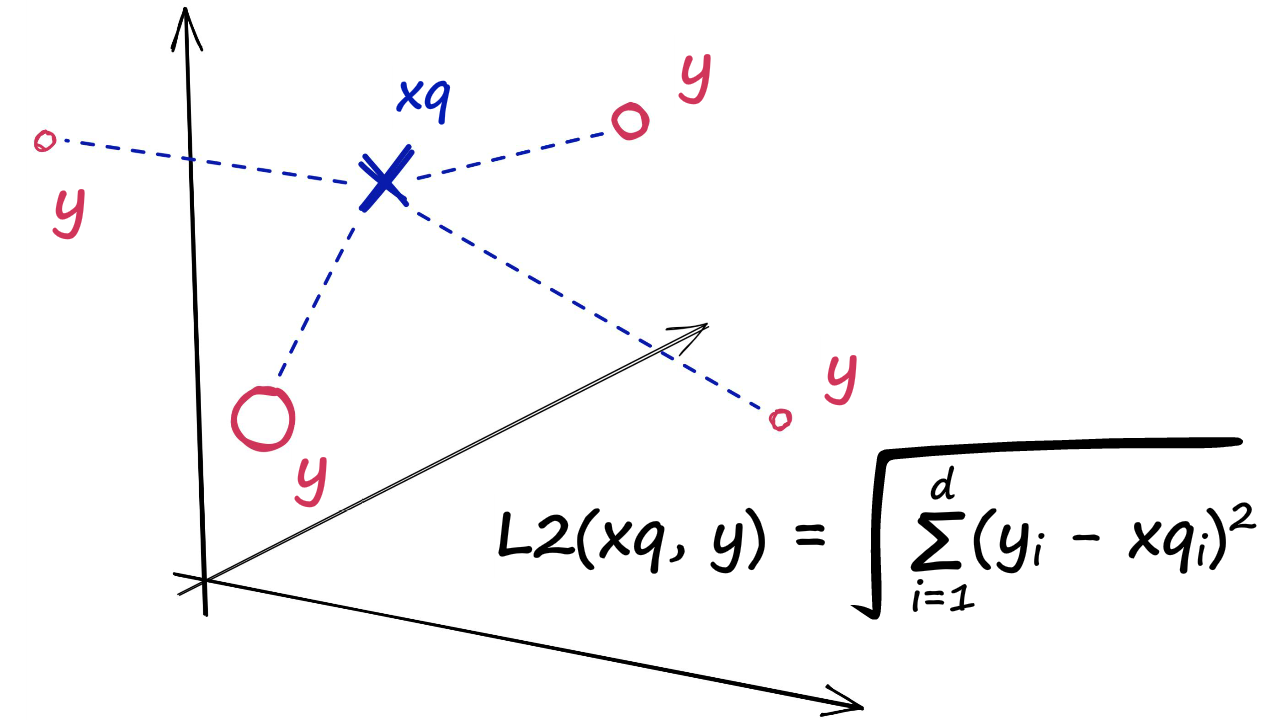

In [7]:
from IPython.core.display import Image, display
display(Image(filename='/Users/ankitkothari/Documents/gdrivre/UMD/CORISE/faiss2_indexFlatL2.png', width=500, unconfined=True))

In [8]:
%%time
index1 = faiss.IndexFlatL2(D)   # build the index
index1.add(embeddings)          # add vectors to the index
print("total number of vectors indexed = ",index1.ntotal)

total number of vectors indexed =  1000000
CPU times: user 65.1 ms, sys: 2.01 ms, total: 67.1 ms
Wall time: 64.7 ms


In [9]:
%%time
D, I = index1.search(query_vector, k)
print("distances from the k nearest neighbor fetched:", D)
print("indices from the k nearest neighbor fetched:", I)
print("average distance of the k- nearest neighbors fetched: ", D.mean())

distances from the k nearest neighbor fetched: [[0.        4.2204943 4.385453  4.693385 ]]
indices from the k nearest neighbor fetched: [[     2 379284 539651 400245]]
average distance of the k- nearest neighbors fetched:  3.3248332
CPU times: user 32.2 ms, sys: 1.95 ms, total: 34.2 ms
Wall time: 32.2 ms


#### FIASS: Partitioning The Index


- Faiss allows us to add multiple steps that can optimize our search using many different methods. A popular approach is to partition the index into Voronoi cells.
- Using this method, we would take a query vector xq, identify the cell it belongs to, and then use our IndexFlatL2 (or another metric) to search between the query vector and all other vectors belonging to that specific cell. So, we are reducing the scope of our search, producing an approximate answer, rather than exact (as produced through exhaustive search).
- nlist to specify how many partitions (Voronoi cells) we’d like our index to have.
- Now, when we built the previous IndexFlatL2-only index, we didn’t need to train the index as no grouping/transformations were required to build the index. Because we added clustering with IndexIVFFlat, this is no longer the case.

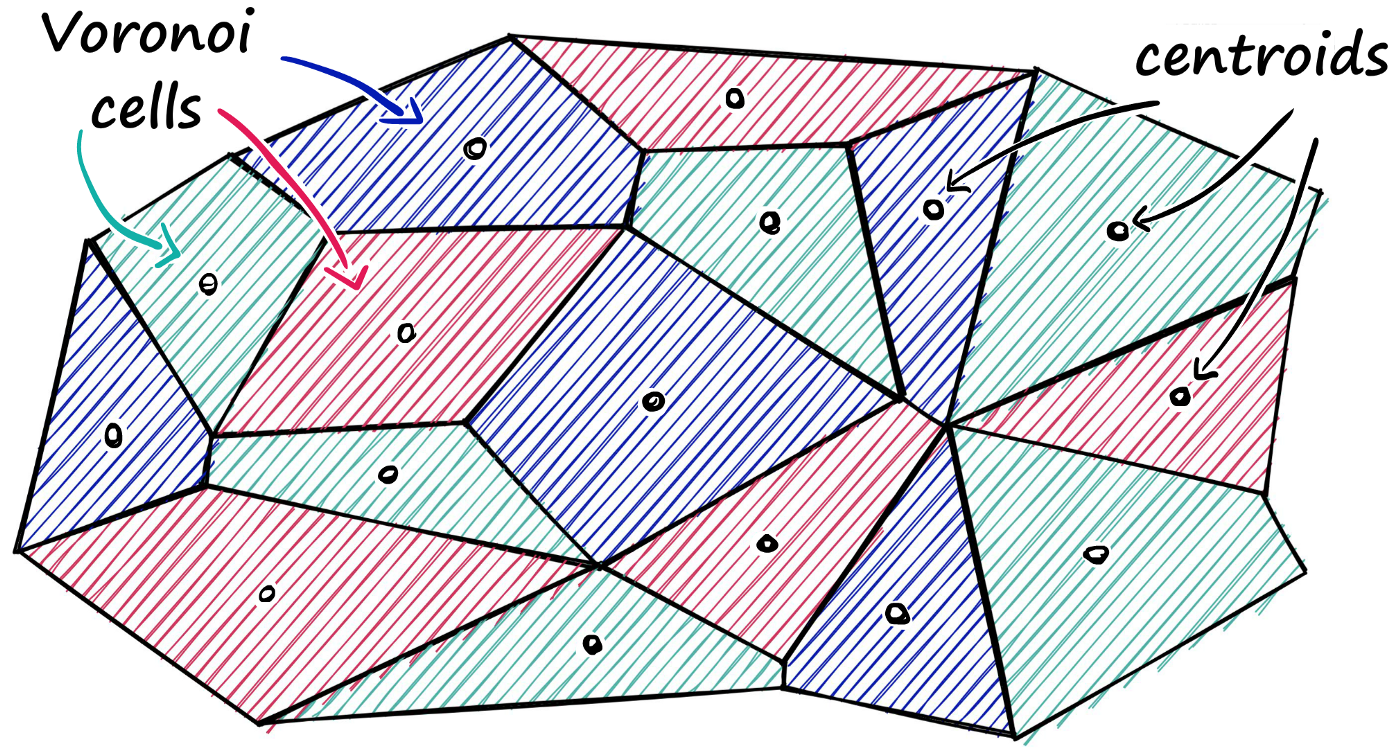

In [10]:
from IPython.core.display import Image, display
display(Image(filename='/Users/ankitkothari/Documents/gdrivre/UMD/CORISE/faiss_partitioning.png', width=500, unconfined=True))

In [11]:
%%time
nlist = 100
D=64
quantizer = faiss.IndexFlatL2(D)  # the other index
index2 = faiss.IndexIVFFlat(quantizer, D, nlist, faiss.METRIC_L2)
index2.train(embeddings)
index2.add(embeddings)
print("total number of vectors indexed = ",index2.ntotal)

total number of vectors indexed =  1000000
CPU times: user 3.14 s, sys: 603 ms, total: 3.74 s
Wall time: 475 ms


In [12]:
%%time
D, I = index2.search(query_vector, k)
print("distances from the k nearest neighbor fetched:", D)
print("indices from the k nearest neighbor fetched:", I)
print("average distance of the k- nearest neighbors fetched: ", D.mean())

distances from the k nearest neighbor fetched: [[0.        5.0635023 5.4133472 5.4525433]]
indices from the k nearest neighbor fetched: [[     2 859123 177280 751466]]
average distance of the k- nearest neighbors fetched:  3.9823482
CPU times: user 8.42 ms, sys: 2.53 ms, total: 10.9 ms
Wall time: 1.79 ms


#### Quantization


- We split the original vector into several subvectors.
- For each set of subvectors, we perform a clustering operation — creating multiple centroids for each sub-vector set.
- In our vector of sub-vectors, we replace each sub-vector with the ID of it’s nearest set-specific centroid.

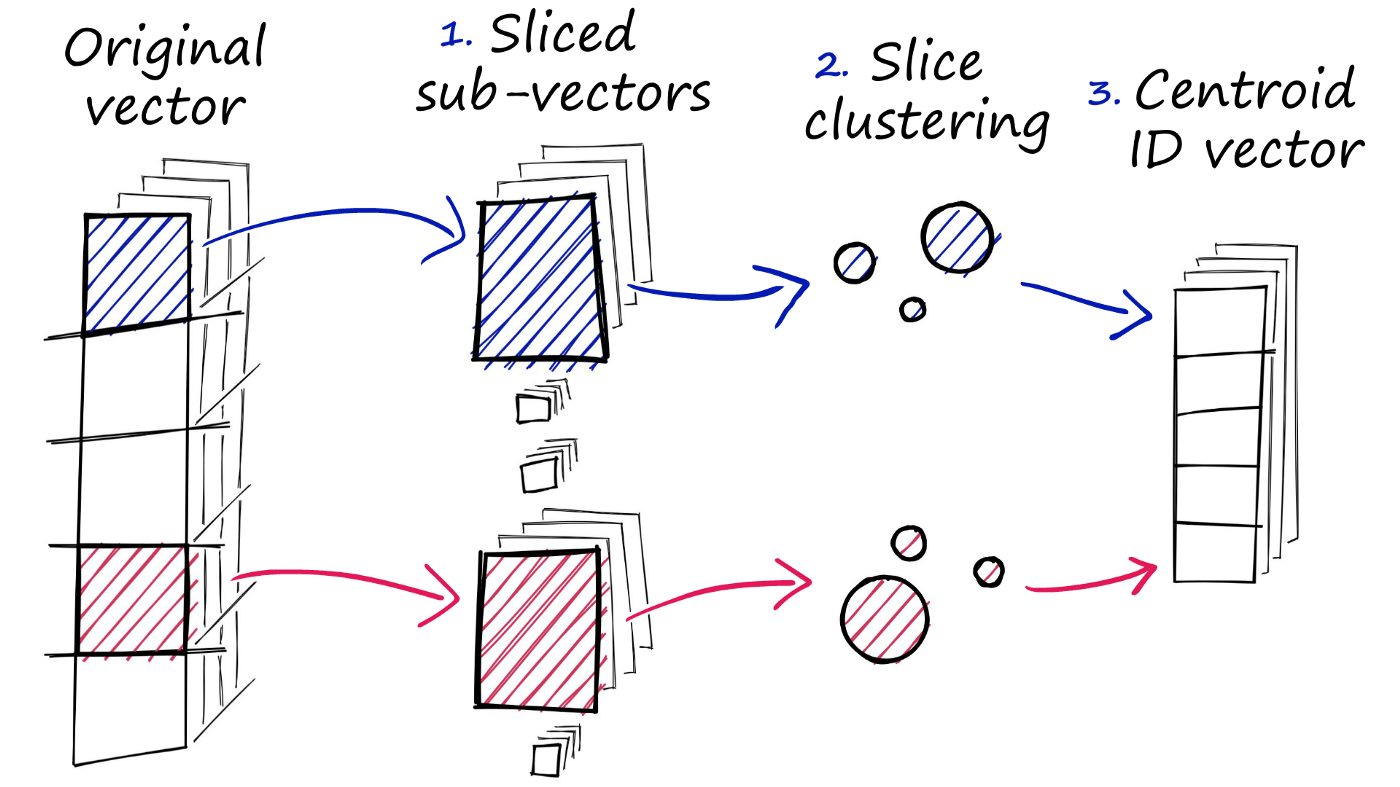

In [13]:
from IPython.core.display import Image, display
display(Image(filename='/Users/ankitkothari/Documents/gdrivre/UMD/CORISE/faiss_quant.png', width=500, unconfined=True))

In [14]:
%%time
nlist = 100 # size of the neighborhood
D=64 # dimension of the embedding
m = 8       # number of centroid IDs in final compressed vectors
k = 4     
quantizer = faiss.IndexFlatL2(D)  
index3 = faiss.IndexIVFPQ(quantizer, D, nlist, m, 8)
                                  # 8 specifies that each sub-vector is encoded as 8 bits
print("IndexIVFPQ: nlist = %d, m = %d" % (nlist, m))
print("IndexIVFPQ: train on %d vectors" % index3.ntotal)
index3.train(embeddings)
index3.add(embeddings)
print("total number of vectors indexed = ",index3.ntotal)

IndexIVFPQ: nlist = 100, m = 8
IndexIVFPQ: train on 0 vectors
total number of vectors indexed =  1000000
CPU times: user 47.7 s, sys: 3.63 s, total: 51.3 s
Wall time: 7.43 s


In [15]:
%%time
D, I = index3.search(query_vector, k)
print("distances from the k nearest neighbor fetched:", D)
print("indices from the k nearest neighbor fetched:", I)
print("average distance of the k- nearest neighbors fetched: ", D.mean())

distances from the k nearest neighbor fetched: [[1.1230184 4.57932   5.0606217 5.2138095]]
indices from the k nearest neighbor fetched: [[     2 950346 229007 703885]]
average distance of the k- nearest neighbors fetched:  3.9941926
CPU times: user 8.2 ms, sys: 2.44 ms, total: 10.6 ms
Wall time: 1.57 ms


## USER REPRESENTATION

- Experimenting with user representations, and how it impacts the performance of downstream tasks.

- To this end, we will work on top of our H&M dataset, and develop a few different ways of representing users.

>The broader framework here will be -- we fix the article representations, and fix the downstream task, and then vary the user representations and see how the performance of the downstream task changes based on different user representation techniques.


In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import gc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import lightgbm as lgb
import datetime
import itertools
import os
from contextlib import redirect_stdout
from tqdm.notebook import tqdm

In [17]:
rand = 64 # random seed
lgb_params = {
    "objective": "binary", # 
    "boosting": "gbdt", # boosting type which means Gradient Boosting Decision Tree. It can be gbdt, gbrt, rf, randomforest, etc.
    "max_depth": -1, # maximum depth of the tree. If set to -1, the depth of the tree is unlimited.
    "num_leaves": 40, # number of leaves in the tree.
    "subsample": 0.8, # subsample ratio of the training instance.
    "subsample_freq": 1, # frequency of subsample, <=0 means no enable
    "bagging_seed": rand, # random seed for bagging
    "learning_rate": 0.05, # learning rate
    "feature_fraction": 0.6, # feature fraction of the training instance.
    "min_data_in_leaf": 100, # minimum data in one leave.
    "lambda_l1": 0, # L1 regularization term on weights.
    "lambda_l2": 0, # L2 regularization term on weights.
    "random_state": rand, # random seed for reproducing results
    "metric": "auc",#"binary_logloss", # metric to be optimized. Can be "l1", "l2", "rmse", "logloss", "binary_logloss", "auc".
    "verbose": -1 # verbose level. 0 is silent, 1 is verbose.
}

tran_dtypes = {"t_dat":"str", 
               "customer_id":"str",
               "article_id":"int",
               "product_code":"int",
               "price":"float",
               "sales_channel_id":"int"}
art_dtypes = {"article_id":"int",
              "product_code":"int",
              "product_type_no":"int",
              "graphical_appearance_no":"int",
              "colour_group_code":"int",
              "department_no":"int",
              "index_code":"str",
              "index_group_no":"int",
              "section_no":"int",
              "garment_group_no":"int"}
cust_dtypes = {"customer_id":"str"}

obj = "class" # "class" or "rank"
N = 15000 # number of training instances
n_iter = 2 # num of iteration
idx_file = "exp1" # index file name
n_round = 2000 # num of rounds
n_splits = 1 # num of splits
nobuy = 20 # num of negative samples

In [18]:
small_customer_set = pd.read_parquet('/Volumes/GoogleDrive/My Drive/data/hmdata/small_customer_set.parquet')
small_article_set = pd.read_parquet('/Volumes/GoogleDrive/My Drive/data/hmdata/small_article_set.parquet')
small_transaction_set = pd.read_parquet('/Volumes/GoogleDrive/My Drive/data/hmdata/small_transaction_set.parquet')

train = pd.read_parquet('/Volumes/GoogleDrive/My Drive/data/hmdata/small_train.parquet')
test = pd.read_parquet('/Volumes/GoogleDrive/My Drive/data/hmdata/small_test.parquet')

In [19]:
small_customer_set.head(2)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,1.0,1.0,ACTIVE,Regularly,56.0,b31984b20a8c478de38eaf113c581ff64e63c4242e607b...
1,00025f8226be50dcab09402a2cacd520a99e112fe01fdd...,1.0,1.0,ACTIVE,Regularly,25.0,a04505cd362b8b1e3f1d8d47d8b31163eae82f078182a1...


In [20]:
small_article_set.head(2)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [21]:
small_transaction_set.head(2)

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,00873fc0f81215241785b49518e6758a2c26c0eac4825e...,633755001,0.006763,1
1,2018-09-20,00873fc0f81215241785b49518e6758a2c26c0eac4825e...,640168001,0.033881,1


#### Item Representation

In [22]:


small_article_set_train  = small_article_set



# Find categorical columns
categorical_encoded_columns = []
total = 0

for col in small_article_set_train.columns:
    if small_article_set_train[col].dtype == "int64" and len(small_article_set_train[col].unique()) <= 500:
        categorical_encoded_columns.append(col)
        total += len(small_article_set_train[col].unique())


# encode categorical columns as one-hot
categorical_col_one_hot_encoded = pd.get_dummies(
    small_article_set_train[categorical_encoded_columns], columns=categorical_encoded_columns).values
print("total categorical columns:", len(categorical_encoded_columns))

# encode text description as tfidf
tfidf = TfidfVectorizer(min_df=3)
tfidf_matrix = tfidf.fit_transform(
    small_article_set_train["detail_desc"].fillna("nodesc"))
print("total tfidf features:", tfidf_matrix.shape[1])


# merge categorical columns and tfidf features
EMBEDDING_SIZE = 64
combined_features = np.hstack((categorical_col_one_hot_encoded.astype(
    "float32"), tfidf_matrix.toarray().astype("float32")))
print("total combined features:", combined_features.shape[1])
svd = TruncatedSVD(n_components=EMBEDDING_SIZE, n_iter=10, random_state=0)
svd.fit(combined_features)
# article_features_embedding is a matrix of shape (n_articles, EMBEDDING_SIZE)
article_features_embedding = svd.transform(combined_features)


np.save("/Volumes/GoogleDrive/My Drive/data/hmdata/article_features_embedding.npy",
        article_features_embedding)

print("article_features_embedding.shape:", article_features_embedding.shape)

total categorical columns: 9
total tfidf features: 2078
total combined features: 2692
article_features_embedding.shape: (71370, 64)


In [23]:
small_article_set_train.head(2)

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.


In [24]:
small_article_set_train.shape

(71370, 25)

In [25]:
def item_representation_1(articles):
    articles = articles.astype(art_dtypes)
    le = LabelEncoder()
    le.fit(articles["index_code"].unique())
    articles["index_code"] = le.transform(articles["index_code"])
    
    dict_vec = {}
    article_embeddings = np.load("/Volumes/GoogleDrive/My Drive/data/hmdata/article_features_embedding.npy")
    print(article_embeddings.shape)
    articles_vector = pd.concat([articles["article_id"],pd.DataFrame(article_embeddings)],axis=1)
    
    return articles_vector

In [26]:
article_svd_features = item_representation_1(small_article_set)
article_svd_features.columns = ['article_id'] + [ f'embed_{x}' for x in article_svd_features.columns[1:]]
article_svd_features.head()


(71370, 64)


,article_id,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,...,embed_54,embed_55,embed_56,embed_57,embed_58,embed_59,embed_60,embed_61,embed_62,embed_63
0,108775015,2.030184,-0.704323,-0.572715,0.098133,0.010271,-0.142845,-0.272513,-0.041125,0.136268,...,-0.347842,-0.081087,0.094365,-0.118458,0.083580,-0.052937,-0.336761,-0.074925,0.251336,-0.092299
1,108775044,1.273103,1.194192,-0.485714,0.896999,0.366522,-0.870475,0.223959,0.029181,0.326217,...,-0.343576,-0.086399,0.112905,-0.102451,0.117709,-0.048292,-0.339060,-0.065891,0.231385,-0.078778
2,108775051,0.824128,1.000420,-0.221533,-0.049422,0.476455,0.363093,-0.103501,0.001328,0.460696,...,-0.332528,-0.098275,-0.067936,0.226598,-0.132129,-0.073352,-0.347812,-0.081930,0.329689,-0.247032
3,110065001,2.044311,-0.696415,-0.809147,-0.073550,0.046004,-0.173411,-0.320210,-0.280931,0.333281,...,0.000458,0.231289,0.052325,0.124196,-0.077061,0.031135,0.144946,0.003376,-0.011536,0.042557
4,110065002,1.287229,1.202100,-0.722146,0.725316,0.402255,-0.901042,0.176262,-0.210625,0.523230,...,0.004724,0.225977,0.070866,0.140203,-0.042932,0.035781,0.142647,0.012411,-0.031488,0.056078


In [27]:
train.head(2)

,t_dat,customer_id,article_id,price,sales_channel_id
811700,2020-06-24,0076383b0cb65133fab3ff5ece40994b8acc055ddb5d18...,826508002,0.016932,1
811701,2020-06-24,0076383b0cb65133fab3ff5ece40994b8acc055ddb5d18...,826508003,0.012695,1


In [28]:
test.head(2)

,t_dat,customer_id,article_id,price,sales_channel_id
883543,2020-09-08,0155a6f04954055d0e916831ebabf8948b8e7edc30e0e3...,855507001,0.009136,1
883544,2020-09-08,0155a6f04954055d0e916831ebabf8948b8e7edc30e0e3...,717490008,0.007610,1


#### Baseline User Representation

In [29]:
def user_representation_1(df_cust):
    df_cust.loc[:,"age"] = df_cust.loc[:,"age"].fillna(df_cust.loc[:,"age"].mean())
    df_cust.loc[:,["FN","Active"]] = df_cust.loc[:,["FN","Active"]].fillna(0)
    df_cust.loc[:,"club_member_status"] = df_cust.loc[:,"club_member_status"].apply(lambda x:1 if x == "ACTIVE" else 0)
    df_cust.loc[:,"fashion_news_frequency"] = df_cust.loc[:,"fashion_news_frequency"].apply(lambda x:0 if x == "NONE" else 1)
    df_cust = df_cust.drop(["postal_code"], axis=1)
    return df_cust

In [30]:
train_customer_set = small_customer_set[small_customer_set.customer_id.isin(train.customer_id.unique())]

user_embeddings1 = user_representation_1(train_customer_set)


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1884: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, val, pi)


In [31]:
user_embeddings1.head(2)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age
0,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,1.0,1.0,1,1,56.0
1,00025f8226be50dcab09402a2cacd520a99e112fe01fdd...,1.0,1.0,1,1,25.0


##### User Representation 2 with a Single Vector
- Average Embedding of all the items the user has bought

In [32]:
customer_vector = train.groupby("customer_id", as_index=False).article_id.agg(['unique']).reset_index()

In [33]:
def average_article_embedding(article_list):
    if len(article_list) == 0:
        return np.zeros(EMBEDDING_SIZE)
    else:
        article_filter = article_svd_features['article_id'].isin(article_list)
        article_svd_feature = np.mean(article_svd_features[article_filter].iloc[:,1:], axis=0) 
        return article_svd_feature




def user_representation_2(customer_vector):
    
    customer_vector_embeddings = customer_vector['unique'].apply(average_article_embedding)
    customer_vector_embeddings = pd.concat([customer_vector['customer_id'], customer_vector_embeddings], axis=1)
    return customer_vector_embeddings


In [34]:
user_as_avg_article_embedding = user_representation_2(customer_vector)

In [35]:
user_as_avg_article_embedding.head(2)

,customer_id,embed_0,embed_1,embed_2,embed_3,embed_4,embed_5,embed_6,embed_7,embed_8,...,embed_54,embed_55,embed_56,embed_57,embed_58,embed_59,embed_60,embed_61,embed_62,embed_63
0,00009d946eec3ea54add5ba56d5210ea898def4b46c685...,1.623544,-0.361915,-0.184361,0.064987,0.165280,0.214204,0.257331,0.023786,0.062484,...,-0.123943,-0.016285,0.126728,0.005163,-0.008713,-0.030662,-0.014395,-0.078260,-0.066969,0.032407
1,00025f8226be50dcab09402a2cacd520a99e112fe01fdd...,0.644928,0.474342,-0.563545,-0.479672,0.260972,0.121718,0.129981,0.102210,-0.098314,...,0.235675,-0.208532,0.157725,-0.143491,0.206074,0.059812,0.953041,0.707022,0.827282,-0.261874


In [36]:
customer_vector_embeddings= customer_vector["unique"].apply(average_article_embedding)

In [37]:
train.head(2)

,t_dat,customer_id,article_id,price,sales_channel_id
811700,2020-06-24,0076383b0cb65133fab3ff5ece40994b8acc055ddb5d18...,826508002,0.016932,1
811701,2020-06-24,0076383b0cb65133fab3ff5ece40994b8acc055ddb5d18...,826508003,0.012695,1


## Training Random Forest Models

In [38]:
train_scaled = pd.read_parquet("/Volumes/GoogleDrive/My Drive/train_data_scaled.parquet")
test_scaled = pd.read_parquet("/Volumes/GoogleDrive/My Drive/test_data_scaled.parquet")

In [39]:
train_scaled.columns

Index(['price', 'is_popular', 'nArticles', 'nDays', 'nPurchases', 'nSect',
       't_dat', 'customer_id', 'product_group_name', 'colour_group_name',
       'section_name', 'age_interval', 'article_id', 'label'],
      dtype='object')

In [40]:
train_scaled.head(2)

,price,is_popular,nArticles,nDays,nPurchases,nSect,t_dat,customer_id,product_group_name,colour_group_name,section_name,age_interval,article_id,label
0,-0.761752,2.193502,0.865999,-0.903131,0.810895,0.200513,2020-06-24,00c571917952c5c99ffb38e7f75b2e91a6b179591cd030...,Garment Upper body,White,Divided Basics,Working Age,678342028,1
1,-0.574314,2.193502,0.865999,-0.903131,0.810895,0.200513,2020-06-24,00c571917952c5c99ffb38e7f75b2e91a6b179591cd030...,Garment Upper body,Black,Womens Everyday Basics,Working Age,863937010,1


In [41]:
test_scaled.head(2)

,price,is_popular,nArticles,nDays,nPurchases,nSect,t_dat,customer_id,product_group_name,colour_group_name,section_name,age_interval,article_id,label
0,-0.378012,2.193502,-0.892372,-0.903131,-0.894557,-0.751731,2020-09-08,05266e627008d4f4e0a51a09f4bae3e2d8e5c45ae3776a...,Garment Lower body,Light Blue,Ladies Denim,Working Age,399256023,1
1,-0.116486,-0.455892,-0.389981,-0.245505,-0.407285,0.200513,2020-09-08,05e0a597465504e1e73bef0b9253cdc6129c8299cb245d...,Garment Upper body,Beige,Womens Tailoring,Middle Age,762846027,1


In [42]:
train_scaled = train_scaled.merge(user_as_avg_article_embedding, on="customer_id", how="left")
test_scaled = test_scaled.merge(user_as_avg_article_embedding, on="customer_id", how="left")

train_scaled = train_scaled.merge(article_svd_features, on="article_id", how="left")
test_scaled = test_scaled.merge(article_svd_features, on="article_id", how="left")


In [43]:
train_scaled.drop(columns=['t_dat','customer_id', 'product_group_name', 'colour_group_name',
       'section_name', 'age_interval', 'article_id'], inplace=True, axis=1)
test_scaled.drop(columns=['t_dat','customer_id', 'product_group_name', 'colour_group_name',
       'section_name', 'age_interval', 'article_id'] , inplace=True, axis=1)

In [44]:
X_train = train_scaled.drop(columns=['label']).values
y_train = train_scaled['label'].values

X_test = test_scaled.drop(columns=['label']).values
y_test = test_scaled['label'].values

In [45]:
type(X_train)

numpy.ndarray

In [46]:
# Trainining a Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)
model.predict(X_test)
print(model.score(X_test, y_test))


0.8564860257271272


In [49]:
# Prinitng a Classification Report
from sklearn.metrics import classification_report
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.86      0.98      0.91     14753
           1       0.86      0.47      0.61      4604

    accuracy                           0.86     19357
   macro avg       0.86      0.73      0.76     19357
weighted avg       0.86      0.86      0.84     19357



[[14393   360]
 [ 2418  2186]]


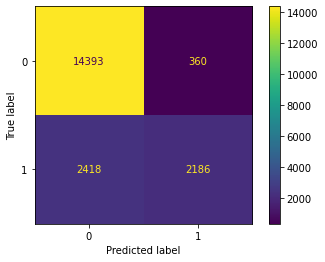

In [53]:
from sklearn.metrics import confusion_matrix
from cProfile import label
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, plot_confusion_matrix


cm = confusion_matrix(y_test, model.predict(X_test))
print(cm)
disp =  ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
disp.plot()
